In [1]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim import Adam

In [3]:
# 1단계
base_dir = "./data"
categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print(" 클래스 목록:", categories)

for cat in categories:
    path = os.path.join(base_dir, cat)
    print(f"{cat} 이미지 개수:", len(os.listdir(path)))


 클래스 목록: ['messy', 'clean']
messy 이미지 개수: 180
clean 이미지 개수: 180


In [14]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

# 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    rc('font', family='Malgun Gothic')
else:  # Linux
    rc('font', family='NanumGothic')

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


In [16]:
from PIL import Image, UnidentifiedImageError
import numpy as np
import os

sizes = []

for cat in categories:
    path = os.path.join(base_dir, cat)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        # 🔹 확장자로 필터링 (추천)
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            continue
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)
        except UnidentifiedImageError:
            print(f"⚠️ 이미지 아님: {img_path}")
            continue

widths, heights = zip(*sizes)
print(f"평균 크기: {np.mean(widths):.1f} x {np.mean(heights):.1f}")


평균 크기: 4164.8 x 3179.9


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def brightness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return np.mean(gray)

brightness_dict = {cat: [] for cat in categories}

for cat in categories:
    path = os.path.join(base_dir, cat)
    for img_name in os.listdir(path)[:30]:  # 샘플 30장만 확인
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)[:, :, ::-1]  # BGR → RGB
        brightness_dict[cat].append(brightness(img))

plt.boxplot([brightness_dict[c] for c in categories], labels=categories)
plt.title("클래스별 평균 밝기 분포")
plt.ylabel("밝기(0~255)")
plt.show()

for cat in categories:
    print(f"{cat} 평균 밝기: {np.mean(brightness_dict[cat]):.1f}")


TypeError: 'NoneType' object is not subscriptable

In [4]:
# 기존 데이터 경로
base_dir = "./data"
src_dirs = ["clean", "messy"]

# 분할 비율
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1

# 분할 폴더 생성
for split in ["train", "val", "test"]:
    for cls in src_dirs:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# 분할 실행
for cls in src_dirs:
    src_path = os.path.join(base_dir, cls)
    images = os.listdir(src_path)
    random.shuffle(images)
    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)

    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train+n_val],
        "test": images[n_train+n_val:]
    }

    for split, img_list in splits.items():
        for img_name in img_list:
            src = os.path.join(src_path, img_name)
            dst = os.path.join(base_dir, split, cls, img_name)
            if not os.path.exists(dst):  # 중복 방지
                shutil.copy(src, dst)

print("데이터 분할 완료")

데이터 분할 완료


In [6]:
# 데이터 경로
data_dir = "./data"

# 데이터 전처리 (Resize + Normalize)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ImageFolder로 불러오기
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_train)
val_data   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val)
test_data  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val)

# DataLoader 구성
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=16, shuffle=False)

print("클래스:", train_data.classes)
print("train 데이터 개수:", len(train_data))
print("val 데이터 개수:", len(val_data))
print("test 데이터 개수:", len(test_data))


클래스: ['clean', 'messy']
train 데이터 개수: 249
val 데이터 개수: 72
test 데이터 개수: 38


In [7]:
# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 중인 디바이스:", device)

# MobileNetV3-Large 사전학습 모델 불러오기
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# 출력층 수정 (clean / messy → 2 클래스)
num_classes = len(train_data.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

# 디바이스로 이동
model = model.to(device)

# 손실함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=3e-4)

print("모델 준비 완료!")

사용 중인 디바이스: cpu
모델 준비 완료!


In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        epoch_loss = running_loss / len(train_data)
        epoch_acc = correct / len(train_data)

        # 검증 단계
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_data)
        val_acc = val_correct / len(val_data)

        print(f"[Epoch {epoch+1}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

#  학습 실행
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

torch.save(model.state_dict(), "checkpoints/mobilenet_baseline.pth")
print("💾 모델 저장 완료!")


[Epoch 1] Train Loss: 0.3745, Train Acc: 0.8554, Val Loss: 0.4137, Val Acc: 0.8611
[Epoch 2] Train Loss: 0.1616, Train Acc: 0.9197, Val Loss: 0.3396, Val Acc: 0.9167
[Epoch 3] Train Loss: 0.0785, Train Acc: 0.9719, Val Loss: 0.2458, Val Acc: 0.8750
[Epoch 4] Train Loss: 0.0337, Train Acc: 0.9960, Val Loss: 0.3174, Val Acc: 0.9028
[Epoch 5] Train Loss: 0.0292, Train Acc: 0.9880, Val Loss: 0.7431, Val Acc: 0.9028
💾 모델 저장 완료!


              precision    recall  f1-score   support

       clean       1.00      0.79      0.88        19
       messy       0.83      1.00      0.90        19

    accuracy                           0.89        38
   macro avg       0.91      0.89      0.89        38
weighted avg       0.91      0.89      0.89        38



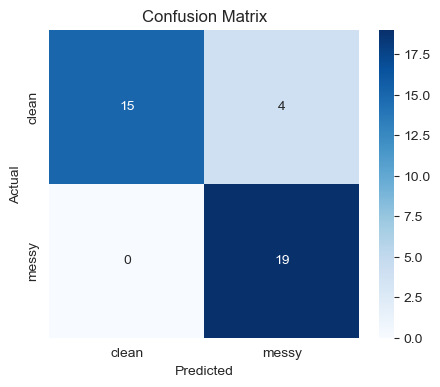

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#  평가 모드
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#  결과 분석
cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
